# [CP07] 앙상블 학습과 랜덤 포레스트 

---
 * 여러 사람에게 질문하고 대답을 모으면 전문가의 답보다 낫다! = **대중의 지혜**
  ###  -> 모델 여러개를 써서 답을 얻어낸다면 더 정확하지 않을까?
   

# 투표 기반 분류기


In [1]:
from sklearn.datasets import make_moons

In [2]:
X, y = make_moons(n_samples=10000, noise = 0.15)

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
                              voting='hard')

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [6]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__,accuracy_score(y_test, y_pred))

LogisticRegression 0.8756
RandomForestClassifier 0.9888
SVC 0.9908
VotingClassifier 0.9916


### 다른 분류기보다 Voting 분류기가 조금 더 괜찮아보인다!
- 작은 샘플(100개)로 학습시키니까 분류기 차이가 별로 안보여서 샘플 사이즈를 10000개로 더 키웠다. 
- 정확도 차이가 약간 보이긴 하지만 그다지 큰 차이는 나지 않는다. 
### 그래도 안쓰는 것 보다 낫다..! 

# 배깅 & 페이스팅
> ## 배깅 : 훈련세트에서 중복을 허용하여 샘플링
> ## 페이스팅 : 중복을 허용하지 않고 샘플링
- 배깅 & 페이스팅은 같은 훈련 샘플을 여러 예측기에 걸쳐 사용가능 
- but 배깅만 같은 샘플을 여러번 샘플링 가능


### 정답 채택 방법? 
    - 분류 : 통계적 최빈값 (가장 많이 나온 값)
    - 회귀 : 평균 
* 개별 예측기는 원본 훈렬세트로 훈련시킨 것보다 훨씬 크게 편향되어있지만, 수집함수를 통과하면 편향과 분산이 모두 감소
* 일반적으로 앙상블의 결과는 원본 데이터셋으로 하나의 예측기를 훈련시킬 때와 비교해 편향은 비슷하지만 분산은 줄어듦
* 편향 : 정답에서 떨어진 정도 / 분산 : 예측값들끼리 퍼진 정도

## Bagging
    - 결정트리 분류기 500개의 앙상블을 훈련시키는 코드
    - 각 분류기는 훈련세트에서 중복을 허용하여 무작위로 선택된 50개(max_samples)의 샘플로 훈련됨 
    - n_jobs : 훈련과 예측에 사용할 CPU 코어 수

In [7]:
X, y = make_moons(n_samples=10000, noise = 0.15)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [8]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=50, bootstrap=True, n_jobs=1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [9]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
import mglearn

In [10]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [11]:
def draw_plot(model,xlabel,ylabel):
  plt.figure(figsize=(15, 8))
  mglearn.plots.plot_2d_classification(model, X_train, alpha=0.5, eps=0.5)
  mglearn.discrete_scatter(X_train[:,0], X_train[:,1], y_train)
  plt.legend()
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)


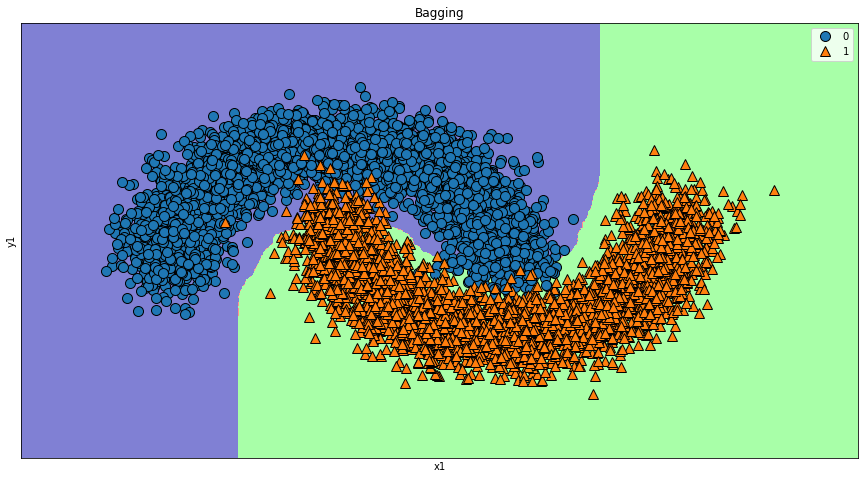

In [12]:
draw_plot(bag_clf, 'x1', 'y1')
plt.title('Bagging')
plt.show()

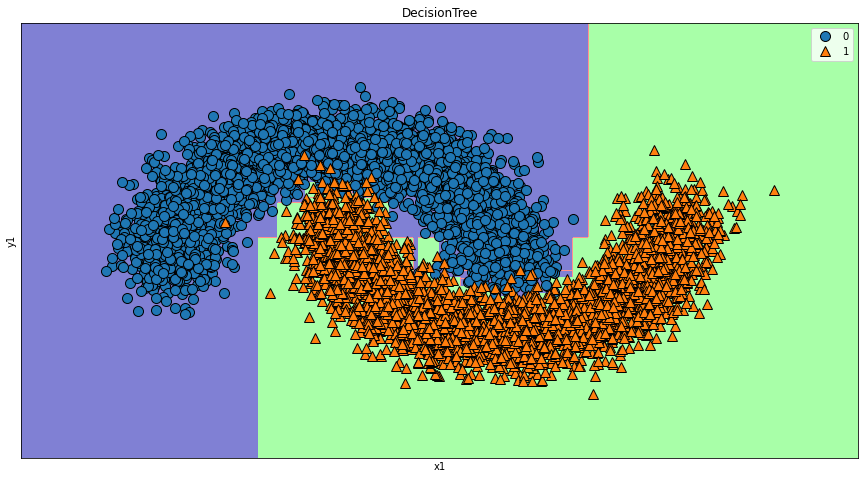

In [13]:
draw_plot(tree, 'x1', 'y1')
plt.title('DecisionTree')
plt.show()

#### DecisionTree 모델의 결정경계는 0 클래스 안에 섞여있는 1 클래스를 완벽히 구분짓기 위해 노력하는게 보인다. (애매하게 생긴 세로선) 
#### Bagging 을 활용한 결정경계가 비교적 일반화가 잘 된 것 같다!

# oob 평가
    - 배깅을 사용하면 어떤 샘플은 한 예측기를 위해 여러 번 샘플링되고 어떤 것은 전혀 선택되지 않을 수 있다. 
    - BaggingClassifier는 기본값으로 중복을 허용하여 훈련세트의 크기만큼인 m개의 샘플 선택함.
      이는 평균적으로 63% 정도만 샘플링됨을 의미함 (= 선택되지 않은 훈련샘플 37%를 oob 샘플이라 함) 
      남겨진 37%는 모두 다르다. 
    - 예측기 훈련되는 동안에는 oob 샘플을 사용하지 않으므로 별도의 검증세트를 사용하지 않고 oob 샘플을 사용해 평가할 수 있다.
    - 앙상블의 평가는 각 예측기의 oob 평가를 평균하여 얻음
   
 * 사이킷런 Baggingclassifier를 만들 때 oob_score = True로 설정하면 훈련이 끝난 후 자동으로 oob 평가 수행 
 

In [14]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500, 
    bootstrap=True, n_jobs=-1, oob_score=True)

In [15]:
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=500,
                  n_jobs=-1, oob_score=True)

### oob 평가 결과

In [16]:
bag_clf.oob_score_

0.9896

    - BaggingClassifier는 테스트 세트에서 약 98.8%의 정확도를 얻을 것으로 보임

In [17]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9868

    - 98.8% 정확도일 것이라고 예측했는데 실제 98.6%로 아주아주 비슷하다!
* oob 샘플에 대한 결정함수의 값도 oob_decision_function_ 변수에서 확인가능 : 각 훈련 샘플의 클래스 확률 반환

In [18]:
bag_clf.oob_decision_function_

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]])

    - oob 평가는 첫번째 훈련샘플이 양성클래스에 속할 확률을 0%로 추정하고 있다. / 음성클래스에 속할 확률 100%

# 랜덤 패치와 랜덤 서브스페이스
    - BaggingClassifier는 특성 샘플링 지원 
        * 샘플링은 max_features, bootstrap_features로 조절
          max_samples, bootstrap과 작동 방식은 동일하지만 샘플이 아니고 특성에 대한 샘플링 
           ==> 따라서 각 예측기는 무작위로 선택한 입력 특성의 일부분으로 훈련됨
* 매우 고차원의 데이터셋(ex. 이미지)을 다룰 때 유용
* 훈련 특성 & 샘플을 모두 샘플링하는 것 = **랜덤 패치 방식** 
* 훈련샘플 모두 사용 & 특성은 샘플링하는 것 = **랜덤 서브스페이스 방식**
* 특성 샘플링은 더 다양한 예측기를 만들고, 편향을 늘리는 대신 분산을 낮춤 = 정답은 덜 맞추는데 예측값끼리 잘 모여있음

# 랜덤 포레스트
    - 일반적으로 배깅 or 페이스팅을 적용한 결정트리 앙상블 
* max_samples를 훈련 세트의 크기로 지정
* 위에서는 BaggingClassifier에 DecisionTreeClassifier를 넣어 만들었는데 이제는 결정트리에 최적화되어 사용하기 편리한 RandomForestClassifier를 사용할 수 있다. 

## 500개 트리로 이루어진 랜덤포레스트 분류기를 여러 CPU코어에서 훈련

In [19]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

    - 랜덤포레스트 알고리즘 : 트리의 노드를 분할할 때 전체 특성 중 최선의 특성을 찾는 대신 무작위로 선택한 특성 후보 중에서 
      최적의 특성을 찾는 식으로 무작위성을 더 주입함
      -> 트리 다양하게 만듦, 편향 증가하지만 분산 낮춰 전체적으로 훌륭한 모델 완성!

### BaggingClassifier를 사용해 위의 RandoForestClassifier와 유사하게 만들기

In [20]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features='auto', max_leaf_nodes=16), 
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)

# 엑스트라 트리
    - 랜덤포레스트에서 트리만들 때 각 노드는 무작위로 특성의 서브셋을 만들어 분할에 사용 
      트리를 더 무작위하게 만들기 위해 최적의 임곗값 찾는 대신 후보 특성을 사용해 무작위로 분할한 다음 그 중에서 최상의 분할 선택
* 이렇게 극단적으로 무작위한 트리의 랜덤포레스트 = 익스트림 랜덤트리(= 엑스트라 트리) 
    - 편향 늘어나지만, 분산 줄여!
        * 모든 노드에서 특성마다 가장 최적의 임곗값 찾는 것 = 트리 알고리즘에서 시간 오래걸리는 작업! 
          때문에 임곗값 찾지 않는 엑스트라 트리가 훨씬 빠르다!

# 특성 중요도
    - 랜덤포레스트는 특성의 상대적 중요도 측정이 쉽다. 
    - sklearn은 어떤 특성을 사용한 노드가 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도 측정 
    - sklearn은 훈련이 끝난 뒤 특성마다 자동으로 이 점수를 계산하고 중요도의 전체 합이 1이 되도록 결괏값을 정규화
    - feature_importance_ 
    

In [21]:
from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris['data'], iris['target'])

for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.09978869603757667
sepal width (cm) 0.0252766822736732
petal length (cm) 0.4407426504289204
petal width (cm) 0.4341919712598297


---
# < 부스팅 >
    - 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블
    - 이전의 모델을 보완해나가면서 일련의 예측기를 학습시키는 것이 아이디어
    - 부스팅 중 가장 인기있는 것 : 에이다부스트, 그레이디언트 부스팅


## 1) 에이다부스트
    - 이전모델 보완방법 : 이전 모델이 과소적합했던 훈련샘플의 가중치를 더 높이기
    - ex. 첫번째 분류기를 훈련세트에서 훈련시키고 예측 만듦 -> 알고리즘이 잘못 분류된 훈련샘플의 가중치를 상대적으로 높임
           -> 두번째 분류기는 업데이트된 가중치를 사용해 훈련세트에서 훈련하고 다시 예측을 만듦 -> 다시 가중치 업데이트
    - 이러한 연속된 학습기법은 경사하강법과 유사
           -> 경사하강법 : 비용함수를 최소화하기 위해 한 예측기의 모델 파라미터 조정
           -> 에이다부스트 : 점차 더 좋아지도록 앙상블에 예측기 추가

* 모든 예측기가 훈련을 마치면 에이다부스트는 배깅, 페이스팅과 비슷한 방식으로 예측 만듦
* but 가중치가 적용된 훈련 세트의 전반적인 정확도에 따라 예측기마다 다른 가중치 적용

* cf. 연속된 학습기법 단점 : 각 예측기는 이전 예측기가 훈련되고 평가된 후 학습가능하기 때문에 병렬화 불가능 -> 배깅, 페이스팅만큼 확장성 높지 않음

### 200개의 얕은 결정트리 기반의 AdaBoostClassifier
    - SAMME : 클래스가 두 개뿐일 때 AdaBoost와 동일 
       * SAMME.R : +예측기가 클래스의 확률 추정 / 예측값 대신 클래스 확률에 기반하며 일반적으로 성능 더 좋음

In [22]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm='SAMME.R', learning_rate=0.5)

ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

---
## 2) 그레이디언트 부스팅
    - 앙상블에 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가 
    - but 에이다부스트처럼 반복마다 샘플의 가중치를 수정하는 대신 이전 예측기가 만든 잔여오차에 새로운 예측기를 학습

### 그레이디언트 트리 부스팅 (= 그레이디언트 부스티드 회귀 트리) 
    - 잡름이 섞인 2차 곡선 형태의 훈련세트


### DecisionTreeRegressor를 훈련세트에 학습

In [23]:
m = 1000
X = 6*np.random.rand(m, 1) - 3
y = X**2 + np.random.randn(m,1)

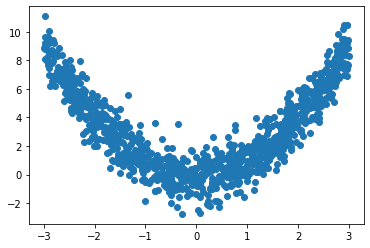

In [24]:
plt.scatter(X, y)

In [25]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2)

#### * 첫 번째 예측기에서 생긴 잔여 오차에 두 번째 DecisionTreeRegressor를 훈련

In [26]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

#### * 두 번째 예측기가 만든 잔여 오차에 세 번쨰 회귀모델 훈련

In [27]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

#### * 세 개의 트리를 포함하는 앙상블 모델 완성 ! 
    - 새로운 샘플에 대한 예측 : 모든 트리의 예측 더하기!

In [28]:
X_new = [[0.8]]

In [29]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [30]:
y_pred

array([[ 0.69053211,  0.69053211,  0.69053211, -3.76060628, -3.76903567,
        -3.76903567, -6.30510465, -3.76903567, -6.30510465, -3.76903567,
         0.69053211, -6.30510465, -6.30510465,  0.69053211, -3.76903567,
        -6.30510465,  0.69053211, -3.76903567,  0.69053211, -3.76060628,
         0.69053211, -3.76903567, -6.30510465,  0.69053211,  0.69053211,
        -3.76903567, -6.30510465, -3.76060628, -3.76903567,  0.69053211,
         0.69053211,  0.69053211,  0.69053211,  0.69053211,  0.69053211,
         0.69053211,  0.69053211, -3.76903567,  0.69053211,  0.69053211,
        -3.76903567,  0.69053211,  0.69053211,  0.69053211,  0.69053211,
         0.69053211,  0.69053211,  0.69053211, -3.76903567, -3.76903567,
         0.69053211,  0.69053211, -3.76903567, -3.76060628, -3.76903567,
        -6.30510465,  0.69053211,  0.69053211,  0.69053211, -3.76903567,
         0.69053211, -3.76903567, -3.76060628, -3.76903567, -3.76903567,
         0.69053211,  0.69053211,  0.69053211,  0.6

### 사이킷런의 GradientBoostingRegressor로 훈련
    - 아래는 이전에 만든 것과 같은 앙상블 만드는 코드

* learning_rate : 매개변수가 각 트리의 기여정도 조절
    - 1.0 처럼 낮게 설정하면, 앙상블을 훈련세트에 학습시키기 위해 많은 트리가 필요하지만, 일반적으로 예측 성능은 좋아짐 = 축소 (규제방법)

In [31]:
from sklearn.ensemble import GradientBoostingRegressor

grbt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
grbt.fit(X, y)

/Users/hayeon/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

    - learning_rate = 0.1 / n_estimators = 3 : 작은 학습률, 너무 적은 나무 갯수 -> 과소적합 
    - learning_rate = 0.1 / n_estimators = 200 : 작은 학습률, 너무 많은 나무 갯수 -> 과대적합

- 최적의 트리갯수를 찾기 위해서 조기종료 사용 가능 
    * 간단히 구현하려면 staged_predict() 메서드 사용 : 훈련 각 단계에서 앙상블에 의해 만들어진 예측기를 순회하는 반복자 반환 


## 최적의 트리 수 찾기 (조기종료)
    - 120개 트리로 GRBT 앙상블 훈련시키고, 최적의 트리 수를 찾기 위해 각 훈련 단계에서 검증오차 측정
      마지막에 최적의 트리 수를 사용해 새로운 GRBT 앙상블 훈련

In [32]:
m = 100
X = 6*np.random.rand(m, 1) - 3
y = 2*X**2 + np.random.randn(m,1)

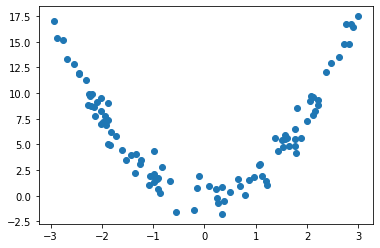

In [33]:
plt.scatter(X, y)

In [34]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y)

grbt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
grbt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
         for y_pred in grbt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

grbt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
grbt_best.fit(X_train, y_train)

/Users/hayeon/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/hayeon/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


GradientBoostingRegressor(max_depth=2, n_estimators=78)

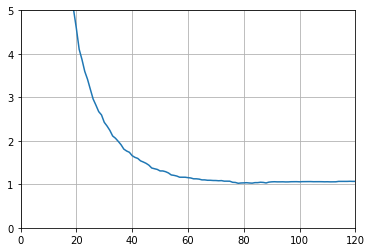

In [35]:
plt.plot(range(1, 121), errors)
plt.xlim(0, 120)
plt.ylim(0, 5)
plt.grid(':')
plt.show()

In [36]:
y_pred_gb = grbt_best.predict(X)

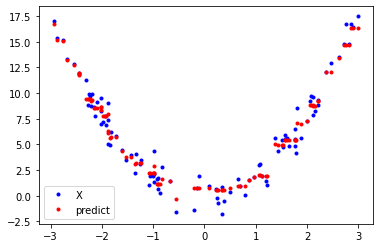

In [37]:
plt.plot(X, y, 'b.', label = 'X')
plt.plot(X, y_pred_gb, 'r.', label = 'predict')
plt.legend()

    - 많은 수의 트리를 학습시키고 최적의 수를 찾는 대신 실제로 훈련을 중지하는 방법으로 조기종료를 구현할 수 있음
    - warm_start = True
    

In [38]:
import warnings
warnings.filterwarnings(action='ignore')

 ### * Gradient Boosting 트리는 각 트리가 훈련할 때 사용할 훈련 샘플의 비율을 지정할 수 있는 subsample 매개변수 지원
    - ex. subsample = 0.25 : 각 트리는 무작위로 선택된 25%의 훈련샘플로 학습 
        - -> 편향이 높아지는 대신 분산이 낮아짐
            : 확률적 그레이디언트 부스팅

In [39]:
grbt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float('inf')
error_going_up = 0
for n_estimators in range(1, 120):
    grbt.n_estimators = n_estimators
    grbt.fit(X_train, y_train)
    y_pred = grbt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up =  0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # 조기종료

## XGBoost (eXtreme Gradient Boosting)
    - 최적화된 그레이디언트 부스팅 구현
    - 매우 빠른 속도 / 확장성 / 이식성
    

In [40]:
!pip install xgboost

You should consider upgrading via the '/Users/hayeon/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [41]:
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

In [42]:
xgb_reg.fit(X_train, y_train, eval_set = [(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)

[0]	validation_0-rmse:5.24054
[1]	validation_0-rmse:4.04827
[2]	validation_0-rmse:3.13754
[3]	validation_0-rmse:2.51402
[4]	validation_0-rmse:2.06243
[5]	validation_0-rmse:1.75335
[6]	validation_0-rmse:1.52532
[7]	validation_0-rmse:1.36474
[8]	validation_0-rmse:1.27046
[9]	validation_0-rmse:1.19880
[10]	validation_0-rmse:1.14865
[11]	validation_0-rmse:1.10700
[12]	validation_0-rmse:1.07130
[13]	validation_0-rmse:1.06135
[14]	validation_0-rmse:1.05166
[15]	validation_0-rmse:1.04436
[16]	validation_0-rmse:1.05019


    - early_stopping_rounds : 더 이상 비용 평가 지표가 감소하지 않는 최대 반복횟수

# 스태킹 (stacked generalization)
    - 앙상블에 속한 모든 예측기의 예측을 취합하는 간단한 함수를 사용하는 대신 취합하는 모델을 훈련시킬 수 없을까? (IDEA)

### * **블렌딩 예측기를 사용한 예측 취합**
    - ex. 세 예측기의 예측값이 나오고 마지막 예측기가 이 예측을 입력으로 받아 최종 예측 만듦
    - 학습 방법 
        * 홀드아웃 세트 사용 : 훈련세트 -> 두개의 서브 세트 -> 첫번쨰 서브셋 : 첫번쨰 레이어의 예측 훈련
                          첫번째 레이어 예측기를 사용해 두번째 세트에 대한 예측 만듦 
                          -> 처음 보는 샘플이 들어갔기 때문에 새로운 예측 만들어짐 
                          -> 홀드아웃세트의 각 샘플에 대해 세개의 예측값 있음 
                          -> 타깃값은 그대로 쓰고, 앞에서 예측한 값을 입력특성으로 사용하여 새로운 훈련세트 생성! 
                          -> 블렌더가 새 훈련세트로 훈련됨 
                          ==> 첫번째 레이어의 예측을 가지고 타깃값 예측하도록 학습


* 이런 **블렌더**를 여러개 훈련시키는 것 가능! (ex. 선형회귀 + 랜덤포레스트회귀) => 블렌더만의 레이어 만들어짐
  * 1. 훈련세트를 세 개의 서브셋으로 만듦
  * 2. 첫번째 세트는 첫번째 레이어를 훈련시키는 데 사용
  * 3. 두번째 세트는 첫번째 레이어의 예측기로 두번째 레이어를 훈련시키기 위한 훈련세트 만드는데 사용
  * 4. 세번째 세트는 두번째 레이어의 예측기로 세번째 레이어를 훈련시키기 위한 훈련세트 만드는데 사용
  * 5. 작업이 끝나면, 각 레이어를 차례대로 실행해서 새로운 샘플에 대한 예측 만들 수 있음
  
* cf) sklearn은 스태킹 지원 X